<a href="https://colab.research.google.com/github/yongtaoliu/Ferroelectric-wall-dynamics-and-pinning-mechanisms/blob/main/Ferroelectric_DW_dynamics_Notebook2_Disentangling_DW_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Disentangling ferroelectric wall dynamics**

May, 2021

- Project lead by [Sergei V. Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)
- PZT IDS-PFM data by [Roger Proksch](https://scholar.google.com/citations?hl=en&user=8OjHap0AAAAJ&view_op)
- rVAE realized via atomai by [Maxim Ziatdinov](https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en)
- Detailed analyses by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)

Package Version:


*   atomai: 0.3.5
*   numpy: 1.19.5
*   matplotlib: 3.2.2
*   cv2: 4.1.2
*   skimage: 0.16.2
*   scipy: 1.4.1

In [ ]:
#@title Download AtomAI
!pip install -q atomai==0.3.5

     |████████████████████████████████| 61kB 2.3MB/s 


In [ ]:
#@title Import
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
import atomai as aoi

from atomai.utils import extract_patches_ 
from atomai.experimental import vae
from skimage import feature
from scipy.ndimage.filters import gaussian_filter
from atomai import utils
from scipy.stats import norm
from skimage.util import invert
from skimage.morphology import convex_hull_image

### Download and load phase images

In [ ]:
#@title Download Data
!gdown https://drive.google.com/uc?id=1CTKMiud-KnRPzBe__UAfNZB4pE8rkG1h   #download phase images


Downloading...
From: https://drive.google.com/uc?id=1CTKMiud-KnRPzBe__UAfNZB4pE8rkG1h
To: /content/test_imgs2_phase.npy
133MB [00:02, 61.2MB/s]


In [ ]:
pha_imgs = np.load('test_imgs2_phase.npy')           #load phase images

### Generate 180 Wall Images

In [ ]:
#deonise phase images first
pha_imgs_g = gaussian_filter(pha_imgs, sigma = 1.0)   

#predict 180 walls in phase images by Canny filter 
pha_wall_ = np.zeros_like(pha_imgs_g) #initializ an array for saving 180 wall images
for i in range (39):
    pha_wall_[i,...] = feature.canny(pha_imgs_g[i,...], sigma=3.0)

### Prepare data for VAE analysis

Two datasets will be prepared
*   First dataset includes forward time delay by comparing t vs t+1
*   Second dataset includes reverse time delay by comparing t vs t-1



In [ ]:
#initialize array for saving phase and 180 wall images
wallimg = np.zeros ((37, 400, 400))
rawimg = np.zeros ((37, 400, 400))

#Prepare phase and 180 wall images. Remove first two frames due to high noise
for i in range (37):
  wallimg[i,...] = cv2.resize(pha_wall_[i+2,5:-5,5:-5], (400,400))
  rawimg[i,...] = cv2.resize(pha_imgs[i+2,5:-5,5:-5],(400,400))

#Normalize phase and 180 wall images
for i in range (37):
  wallimg[i,...] = (wallimg[i,...]-wallimg[i,...].min())/(wallimg[i,...].max()-wallimg[i,...].min())
  rawimg[i,...] = (rawimg[i,...]-rawimg[i,...].min())/(rawimg[i,...].max()-rawimg[i,...].min())

Forward dataset

(-0.5, 399.5, 399.5, -0.5)

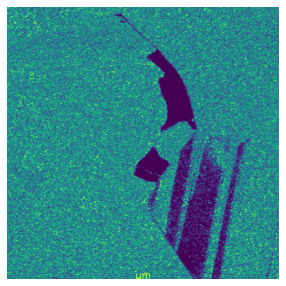

In [ ]:
#make image set for t and t+1
im = np.zeros_like(rawimg)
im = np.append(im,im[:-1,...], axis = 0)
im[0,...]= rawimg[0,...]
for i in range (1,37):
  im[i*2]=rawimg[i]
  im[i*2-1]=rawimg[i]

#Show the last phase and corresponding 180 wall images
f, ax1= plt.subplots(figsize= (5,5))
ax1.imshow(im[-1,...])
ax1.axis('off')

Reverse time delay dataset

(-0.5, 399.5, 399.5, -0.5)

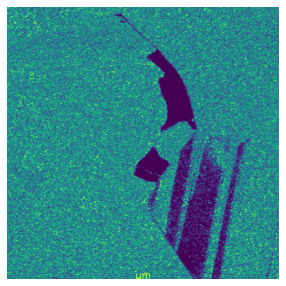

In [ ]:
#flip the sequency of phase and 180 wall images to customize wall motion
r = rawimg
w = wallimg
rawimg_r = np.flip(r, axis = 0)
wallimg_r = np.flip(w, axis = 0)

#make image set for t and t-1
im_r = np.zeros_like(rawimg_r)
im_r = np.append(im_r,im_r[:-1,...], axis = 0)
im_r[0,...]= rawimg_r[0,...]
for i in range (1,37):
  im_r[i*2]=rawimg_r[i]
  im_r[i*2-1]=rawimg_r[i]

#show the first phase and 180 wall images in the flipped dataset
f, ax1= plt.subplots(figsize= (5,5))
ax1.imshow(im_r[0,...])
ax1.axis('off')

### Prepare wall coordinate dataset for extracting sub-images

Two coordinate datasets will be prepared:


*   First coordinate dataset is for the forward time delay t vs t+1
*   Second coordinate dataset is for the reverse time delay t vs t-1
*   Both coordinate datasets are 180 wall coordinates

In [ ]:
#first coordinate dataset for forward time delay t vs t+1
wi = wallimg

dictionary = {}

wall_cor = ()
for i in range (37):
  index = np.where(wi[i,...]!=0)
  wall_cor = wall_cor+index

cor = np.array(wall_cor)

for j in range (37):
  d = np.array([[0],[0],[0]])
  for i in range (len(cor[j*2,])):
    d = np.append(d,[[cor[j*2][i]], [cor[j*2+1][i]], [0]], axis =1)
  d=d.T
  #control coordinates size to 80
  A = np.arange(len(d))
  idx = np.random.choice(A, 80, replace = False)
  B = d[idx,]
  dictionary [j*2] = np.array(B)
  dictionary [j*2+1] = np.array(B)

coordinates = dictionary
coordinates.pop(73);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
#first coordinate dataset for forward time delay t vs t-1
wi = wallimg_r

dictionary = {}

wall_cor = ()
for i in range (37):
  index = np.where(wi[i,...]!=0)
  wall_cor = wall_cor+index

cor = np.array(wall_cor)

for j in range (37):
  d = np.array([[0],[0],[0]])
  for i in range (len(cor[j*2,])):
    d = np.append(d,[[cor[j*2][i]], [cor[j*2+1][i]], [0]], axis =1)
  d=d.T
  #control coordinates size to 80
  A = np.arange(len(d))
  idx = np.random.choice(A, 80, replace = False)
  B = d[idx,]
  dictionary [j*2] = np.array(B)
  dictionary [j*2+1] = np.array(B)

coordinates_r = dictionary
coordinates_r.pop(73);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


### rVAE train


*   For the convenience of readers, trained model weights can be directly download after the training cell



rVAE train for forward time delay dataset t vs t+1

In [ ]:
# extract subimage dataset
imstack, com, frames = utils.extract_subimages(im, coordinates, 80)
# train VAE using the constructed stack of subimages
rvae = vae.rVAE(imstack, minibatch_size=50, training_cycles=500, numhidden_encoder=512, numhidden_decoder=512)
rvae.run()

In [ ]:
rvae_ws80 = rvae

rVAE train for reverse time delay dataset t vs t-1

In [ ]:
#extract subimage dataset
imstack, com, frames = utils.extract_subimages(im_r, coordinates_r, 80)
# train VAE using the constructed stack of subimages
rvae = vae.rVAE(imstack, minibatch_size=50, training_cycles=500, 
                numhidden_encoder=512, numhidden_decoder=512)
rvae.run()

In [ ]:
rvae_ws80_r = rvae

Optional: Download and load trained models
- rvae_ws80: model of forward time delay
- rvae_ws80_r: model of reverse time delay

In [ ]:
#@title Optional: download and load trained weights
!gdown https://drive.google.com/uc?id=1-5TIhW2zDMAEqzHvZ6kHoR5eQnf9b2oK
!gdown https://drive.google.com/uc?id=1-FZrYbddEREr98a9CmlLDSD4bD_gkgBV

#load weights
rvae_ws80 = vae.EncoderDecoder((80,80), 2, numhidden_encoder=512, numhidden_decoder=512)
rvae_ws80.load_weights("rVAE_DW@center_Pha_t&t+1_ws80.tar")

rvae_ws80_r = vae.EncoderDecoder((80,80), 2, numhidden_encoder=512, numhidden_decoder=512)
rvae_ws80_r.load_weights("rVAE_DW@center_Pha_t&t+1_reverse_ws80.tar")

In [ ]:
rvae_models=[rvae_ws80, rvae_ws80_r]

### Plot manifold2D

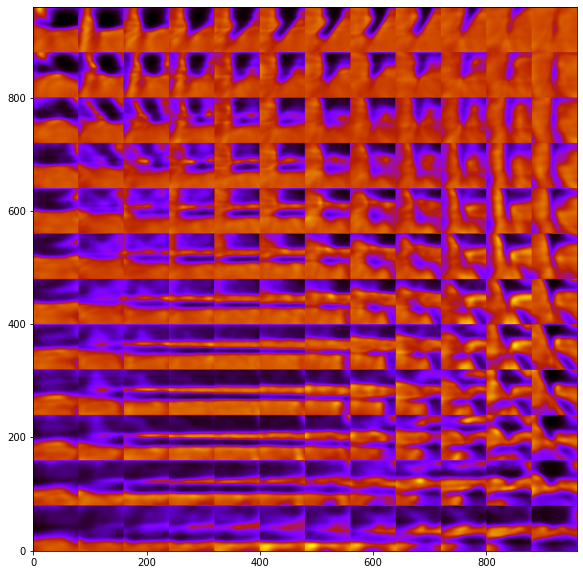

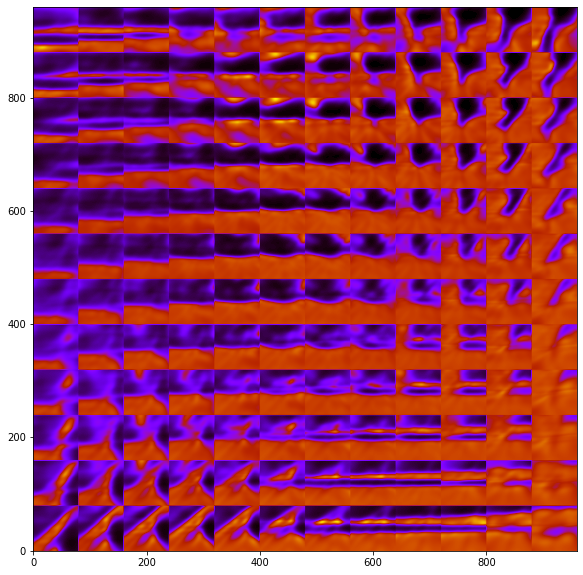

In [ ]:
for rvae_ in rvae_models:
    rvae_.manifold2d(d=12)

## Analyze latent space

In [ ]:
#initialize a latent space figure with grid = 100 for analysis
d =100     #grid size
grid_x = norm.ppf(np.linspace(0.05, 0.95, d))
grid_y = norm.ppf(np.linspace(0.05, 0.95, d))

rvae_ = rvae_ws80    #if want to look at reverse time delay result, change rvae_ to rvae_ws80_r
ws = 80

figure = np.zeros((ws*d, ws*d))
for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    imdec = rvae_.decode(z_sample)
    figure[i * ws: (i + 1) * ws, j * ws: (j + 1) * ws] = imdec
if figure.min() < 0:
  figure = (figure - figure.min()) / figure.ptp()

### Show the distribution of domain wall number in latent space

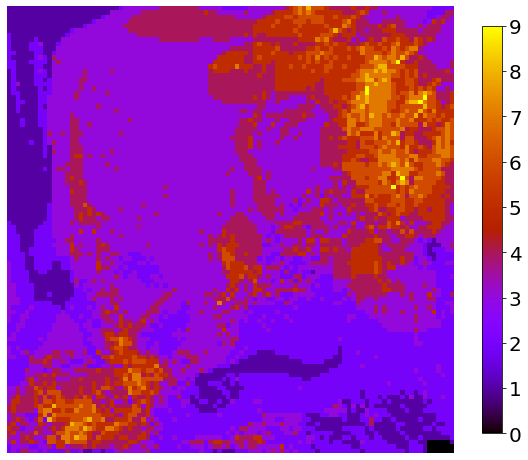

In [ ]:
#count wall number
fig = figure
edge = np.zeros_like(fig)
#edge detector sigma
sigma = 2
#set array for saving wall numbers
count_wall = np.zeros((d,d))

for i in range (d):
  for j in range (d):
    subimg = fig[ws*i: ws*(i+1), ws*j:ws*(j+1)]
    edge_ = feature.canny(subimg, sigma = sigma)
    edge[ws*i: ws*(i+1), ws*j:ws*(j+1)] = edge_
    labelimage = skimage.measure.label(edge_, connectivity=2, return_num=False)
    n = labelimage.max()
    count_wall[i,j] = n

f, ax = plt.subplots(figsize = (10,10))
c = count_wall
plt.imshow(c, cmap = 'gnuplot')
ax.axis('off')
cbar = plt.colorbar(shrink = 0.75)
cbar.ax.tick_params(labelsize=20)

### Show the distribution of domain convex in latent space

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  if sys.path[0] == '':


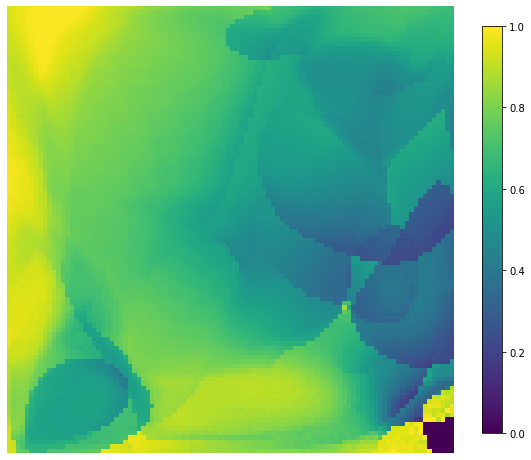

In [ ]:
fig = figure

#set array for saving convex
convex = np.zeros((d,d))

for i in range (d):
  for j in range (d):
    subimg = fig[ws*i: ws*(i+1), ws*j:ws*(j+1)]
    #calculate convex
    ret,subimg1 = cv2.threshold(subimg,0.2,1,cv2.THRESH_BINARY)  #binary
    subimg2 = invert(subimg1)     #invert 0<-->1
    chull = convex_hull_image(subimg2)        #find polygon
    A_con = np.count_nonzero(chull==True)       #polygon area represented as the number of pixel =1
    A = np.count_nonzero(subimg2==True)        #image area: number of pixel = 1
    if A_con == 0:
      R_con = 0
    else:
      R_con = A/A_con                        #convexity = Area of image/ area of polygon
    convex[i,j] = R_con

f, ax = plt.subplots(figsize = (10,10))
plt.imshow(convex)
ax.axis('off')
plt.colorbar(shrink = 0.75)
plt.show()

### Show the distribution of domain convex in latent space

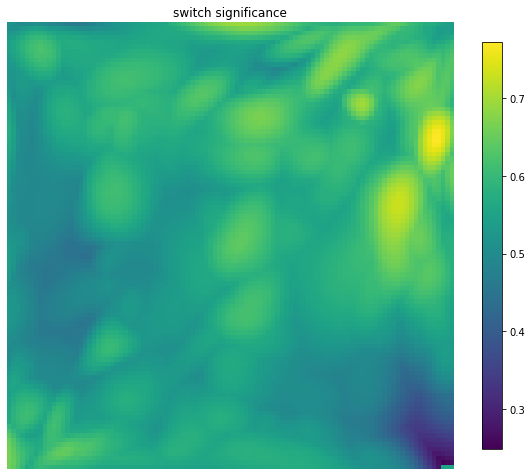

In [ ]:
fig = figure

#set array for switch significance
swsig = np.zeros((d,d))

for i in range (d):
  for j in range (d):
    subimg = fig[ws*i: ws*(i+1), ws*j:ws*(j+1)]
    #calculate switching significance
    ret,subimg1 = cv2.threshold(subimg,0.3,1,cv2.THRESH_BINARY)  #binary
    if subimg[np.where(subimg1 == 0)].size == 0:
      down_min = 0
    else:
      down_min = subimg[np.where(subimg1 == 0)].min()
    if subimg[np.where(subimg1 == 1)].size == 0:
      up_max = 0
    else:
      up_max = subimg[np.where(subimg1 == 1)].max()
                        
    swsig[i,j] = up_max - down_min

f, ax = plt.subplots(figsize = (10,10))
plt.imshow(swsig)
plt.title('Switch significance', fontsize = 15)
ax.axis('off')
plt.colorbar(shrink = 0.75)
plt.show()

## Analyze the latent variables and wall dynamics

### Prepare image and wall datasets for analysis

In [ ]:
pha_imgs_g = gaussian_filter(pha_imgs, sigma = 0.9)

#Compute the Canny filter for two values of sigma
wall_img = np.zeros_like(pha_imgs_g)

for i in range (39):
  wall_img[i,...] = feature.canny(pha_imgs_g[i,...], sigma=2.8)

In [ ]:
#cut a set of subimage/wall image that only contain a continuous wall
k1=130; k2 = 250; h1= 390; h2=430
cur_wall = np.zeros((18,h1-k1,h2-k2))
img_cut = np.zeros((18,h1-k1,h2-k2))
for i in range (19,37):
  cur_wall[i-19,...]=wall_img[i,k1:h1, k2:h2]
  cur_wall[i-19,...] = skimage.measure.label(cur_wall[i-19,...], connectivity=2, return_num=False)
  img_cut[i-19,...] = pha_imgs[i,k1:h1, k2:h2]

In [ ]:
#delete tiny walls and only leave the continous wall
for i in range(18):
  for j in range(h1-k1):
    for k in range(h2-k2):
      if cur_wall[i,j,k]!=1:   #only keep the continuous wall
        cur_wall[i,j,k]=0

### Wall evolution

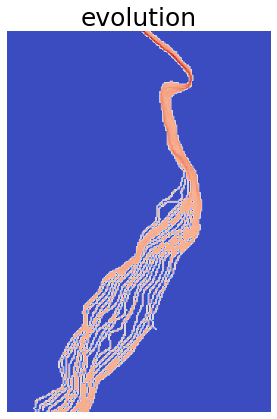

In [ ]:
#make an image containing all walls in above 18 frames to show the wall evolution
evo_wall = np.sum(cur_wall, axis=0)
for j in range(h1-k1):
  for k in range(h2-k2):
    if evo_wall[j,k] == 0:
        evo_wall[j,k] = -30
f, ax = plt.subplots(figsize = (7,7))
ax.imshow(evo_wall, cmap = 'coolwarm')
ax.set_title('Evolution',fontsize = 20)
ax.set_axis_off()

### Color the wall evolution image by latent variables

In [ ]:
#make wall coordinates for walls in above 18 frames
wall_cor = ()

for i in range (18):
  index = np.where(cur_wall[i,...]==1)
  wall_cor = wall_cor+index

cor = np.array(wall_cor)

dictionary = {}
for j in range (18):
  d = np.array([[0],[0],[0]])
  for i in range (len(cor[j*2,])):
    d = np.append(d,[[cor[j*2][i]], [cor[j*2+1][i]], [0]], axis =1)
  d=d.T
  dictionary [j] = d

coordinates = dictionary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


Color the wall-evolution image by latent variables: forward time delay

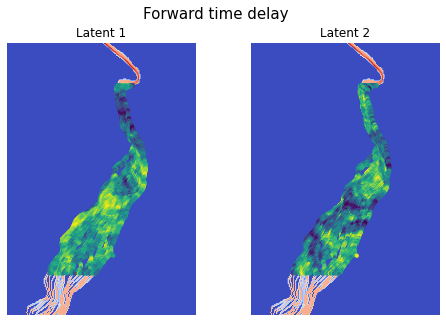

In [ ]:
imstack, com, frames = utils.extract_subimages(cur_wall, coordinates, window_size=80)
z_mean, z_sd = rvae_ws80.encode(imstack)

f, (ax1, ax2) = plt.subplots(1,2, figsize = (8,5))
f.suptitle('Forward time delay', fontsize = 15)
ax1.imshow(evo_wall, cmap = 'coolwarm')
ax1.set_title('Latent 1')
ax1.axis('off')
ax2.imshow(evo_wall, cmap = 'coolwarm')
ax2.set_title('Latent 2')
ax2.axis('off')

for i in range (18):
  im = cur_wall[i,...]
  coor = com[np.where(frames == i)]
  z = z_mean[np.where(frames == i)]
  ax1.scatter(coor[:,1], coor[:,0], c = z[:,-2], s = 10)
  ax2.scatter(coor[:,1], coor[:,0], c = z[:,-1], s = 10)

Color the wall-evolution image by latent variables: reverse time delay

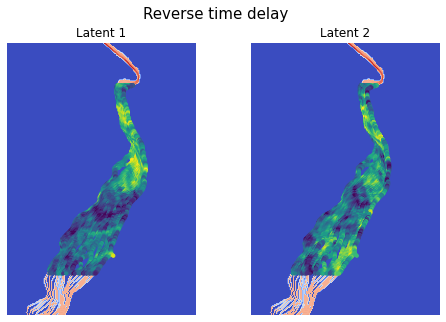

In [ ]:
imstack, com, frames = utils.extract_subimages(cur_wall, coordinates, window_size=80)
z_mean, z_sd = rvae_ws80_r.encode(imstack)

f, (ax1, ax2) = plt.subplots(1,2, figsize = (8,5))
f.suptitle('Reverse time delay', fontsize = 15)
ax1.imshow(evo_wall, cmap = 'coolwarm')
ax1.set_title('Latent 1')
ax1.axis('off')
ax2.imshow(evo_wall, cmap = 'coolwarm')
ax2.set_title('Latent 2')
ax2.axis('off')

for i in range (18):
  im = cur_wall[i,...]
  coor = com[np.where(frames == i)]
  z = z_mean[np.where(frames == i)]
  ax1.scatter(coor[:,1], coor[:,0], c = z[:,-2], s = 10)
  ax2.scatter(coor[:,1], coor[:,0], c = z[:,-1], s = 10)
  